# SAS analysis

Análisis de similitud estructura-actividad.

## 0. Prepare files
[Python Kernel]

In [12]:
%%bash
FILE=Phenylimidazoles.csv

# CSV
# echo "ID,SMILES,pIC50" > DB.csv
# sed 1d $FILE | cat -b | awk '{print $3","$4}' > DB_1.csv
# awk '{print $1,"0,"}' sinprotonar.smi | sort | uniq >DB_2.csv       #Vamos a unir los de ligbuilder
# echo "ID,SMILES,pIC50" |cat -b DB_1.csv DB_2.csv |awk '{print $1","$2","$3}' >>DB.csv
# rm DB_*

#Vamos a quitar 377 378 379 380 447

# SMI
# sed 1d $FILE | cat -b | awk '{print $3}' > DB2.smi
sed 1d DB.csv | cut -d',' -f2  | cat -b | awk '{print $2,$1}' | sed 's/ /\t/g' > DB.smi
sed 1d DB.csv | cut -d',' -f2  > DB2.smi

# SDF
# obabel -i smi DB.smi -o sdf -O DB.sdf --gen3D > DB.sdf

## I. Fingerprints

### I.1. MayaChemTools FPs
[Python Kernel]

#### I.1.1. FP calculation

In [1]:
%%bash
MACCSKeysFingerprints.pl -size 166 -r MACCS166 -o DB.sdf > out
MACCSKeysFingerprints.pl -size 322 -r MACCS322 -o DB.sdf > out
AtomNeighborhoodsFingerprints.pl -r ANH -o DB.sdf > out
AtomTypesFingerprints.pl -r AT -o DB.sdf > out
EStateIndiciesFingerprints.pl -r ESI -o DB.sdf > out
ExtendedConnectivityFingerprints.pl -r ECFP -o DB.sdf > out
PathLengthFingerprints.pl -r PL -o DB.sdf > out
TopologicalAtomPairsFingerprints.pl -r TAPair -o DB.sdf > out
TopologicalAtomTorsionsFingerprints.pl -r TATor -o DB.sdf > out
TopologicalAtomTripletsFingerprints.pl -r TATri -o DB.sdf > out
TopologicalPharmacophoreAtomPairsFingerprints.pl -r TPAP -o DB.sdf > out
TopologicalPharmacophoreAtomTripletsFingerprints.pl -r TPAT -o DB.sdf > out

In [2]:
%%bash
EStateIndiciesFingerprints.pl -r ESI -o DB.sdf -e FixedSize > out

#### I.1.2. Similarity matrix

In [3]:
%%bash
SimilarityMatricesFingerprints.pl -o MACCS166.csv -p 4 > out
SimilarityMatricesFingerprints.pl -o MACCS322.csv -p 4 > out
SimilarityMatricesFingerprints.pl -o ANH.csv -p 4 > out
SimilarityMatricesFingerprints.pl -o AT.csv -p 4 > out
SimilarityMatricesFingerprints.pl -o ESI.csv -p 4 > out
SimilarityMatricesFingerprints.pl -o ECFP.csv -p 4 > out
SimilarityMatricesFingerprints.pl -o PL.csv -p 4 > out
SimilarityMatricesFingerprints.pl -o TAPair.csv -p 4 > out
SimilarityMatricesFingerprints.pl -o TATor.csv -p 4 > out
SimilarityMatricesFingerprints.pl -o TATri.csv -p 4 > out
SimilarityMatricesFingerprints.pl -o TPAP.csv -p 4 > out
SimilarityMatricesFingerprints.pl -o TPAT.csv -p 4 > out

In [4]:
%%bash
SimilarityMatricesFingerprints.pl -o ESI.csv -p 4 > out

### I.2. RDKit
[Python Kernel]

#### I.2.0. Libraries and Functions

In [5]:
from rdkit import Chem
from rdkit.DataManip.Metric import GetTanimotoSimMat
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem.AtomPairs import Torsions

import numpy as np
import pandas as pd

def matriz(tri_arr):
    n = len(tri_arr)
    m = int((np.sqrt(1 + 4 * 2 * n) + 1) / 2)
    arr = np.ones([m, m])
    for i in range(m):
        for j in range(i):
            arr[i][j] = tri_arr[i + j - 1]
            arr[j][i] = tri_arr[i + j - 1]
    return arr

#### I.2.1. Read input file

In [6]:
kitf = Chem.SDMolSupplier('DB.sdf')

#### I.2.2. FP calculation and Similarity matrix

In [7]:
kitfp1=np.around(matriz(GetTanimotoSimMat([Chem.RDKFingerprint(x) for x in kitf])), decimals=6)
kitfp2=np.around(matriz(GetTanimotoSimMat([MACCSkeys.GenMACCSKeys(x) for x in kitf])), decimals=6)
kitfp3=np.around(matriz(GetTanimotoSimMat([Pairs.GetAtomPairFingerprintAsBitVect(x) for x in kitf])), decimals=6)
kitfp4=np.around(matriz(GetTanimotoSimMat([AllChem.GetMorganFingerprintAsBitVect(x,2,nBits=1024) for x in kitf])), decimals=6)

pd.DataFrame(kitfp1).to_csv("RDKfp.csv")
pd.DataFrame(kitfp2).to_csv("RDKmaccs166.csv")
pd.DataFrame(kitfp3).to_csv("RDKpairs.csv")
pd.DataFrame(kitfp4).to_csv("RDKmorgan.csv")

### I.3. RCDK FPs
[R Kernel]

#### I.3.0. Libraries

In [1]:
library(reshape)
library(rcdk)
library(fingerprint)
library(ggplot2)
# library(Rcpi)

ERROR: Error in library(rcdk): there is no package called ‘rcdk’


#### I.3.1. Read input file

In [3]:
cdkf <- read.csv('DB.csv')
id <- unlist(strsplit(toString(cdkf[['ID']]), split=', '))
smiles <- unlist(strsplit(toString(cdkf[['SMILES']]), split=', '))
mols <- parse.smiles(smiles)

ERROR: Error in parse.smiles(smiles): could not find function "parse.smiles"


#### I.3.2. FP calculation and Similarity matrix

In [3]:
cdkfp1 <- fp.sim.matrix((lapply(mols, get.fingerprint, type='standard')), method='tanimoto')
cdkfp2 <- fp.sim.matrix((lapply(mols, get.fingerprint, type='extended')), method='tanimoto')
cdkfp3 <- fp.sim.matrix((lapply(mols, get.fingerprint, type='graph')), method='tanimoto')
cdkfp4 <- fp.sim.matrix((lapply(mols, get.fingerprint, type='hybridization')), method='tanimoto')
cdkfp5 <- fp.sim.matrix((lapply(mols, get.fingerprint, type='maccs')), method='tanimoto')
cdkfp6 <- fp.sim.matrix((lapply(mols, get.fingerprint, type='estate')), method='tanimoto')
cdkfp7 <- fp.sim.matrix((lapply(mols, get.fingerprint, type='pubchem')), method='tanimoto')
cdkfp8 <- fp.sim.matrix((lapply(mols, get.fingerprint, type='shortestpath')), method='tanimoto')
cdkfp9 <- fp.sim.matrix((lapply(mols, get.fingerprint, type='circular')), method='tanimoto')
#ver <- lapply(mols, get.fingerprint, type='pubchem', fp.mode="bit")
#ver

### I.4. RCPI PubChem FP

#### I.4.1. Read input file

In [4]:
mols <- readMolFromSmi("DB2.smi", type = "mol")

#### I.4.2. FP calculation and Similarity matrix

In [5]:
rcpifp1 <- diag(length(mols))
for (i in 1:length(mols)) {
  for (j in i:length(mols)) {
    fp1 <- extractDrugPubChem(mols[[i]])
    fp2 <- extractDrugPubChem(mols[[j]])
    tmp <- calcDrugFPSim(fp1, fp2, fptype = "compact", metric = "tanimoto")
    rcpifp1[i, j] <- tmp
    rcpifp1[j, i] <- tmp
  }
}

In [6]:
pcbits <- extractDrugPubChemComplete(mols, silent = TRUE)

In [7]:
write.table(pcbits, 'PubchemBitString.csv', sep=' ')

## II. Similarity pairs
[R Kernel]

### II.1. MayaChemTools

In [8]:
mctfp1 <- unname(data.matrix(read.csv('MACCS166TanimotoSimilarity.csv'), rownames.force = NA)[,-1])
mctfp2 <- unname(data.matrix(read.csv('MACCS322TanimotoSimilarity.csv'), rownames.force = NA)[,-1])
mctfp3 <- unname(data.matrix(read.csv('ANHTanimotoSimilarityAlgebraicForm.csv'), rownames.force = NA)[,-1])
mctfp4 <- unname(data.matrix(read.csv('ATTanimotoSimilarityAlgebraicForm.csv'), rownames.force = NA)[,-1])
mctfp5 <- unname(data.matrix(read.csv('ESITanimotoSimilarityAlgebraicForm.csv'), rownames.force = NA)[,-1])
mctfp6 <- unname(data.matrix(read.csv('ECFPTanimotoSimilarityAlgebraicForm.csv'), rownames.force = NA)[,-1])
mctfp7 <- unname(data.matrix(read.csv('PLTanimotoSimilarity.csv'), rownames.force = NA)[,-1])
mctfp8 <- unname(data.matrix(read.csv('TAPairTanimotoSimilarityAlgebraicForm.csv'), rownames.force = NA)[,-1])
mctfp9 <- unname(data.matrix(read.csv('TATorTanimotoSimilarityAlgebraicForm.csv'), rownames.force = NA)[,-1])
mctfp10 <- unname(data.matrix(read.csv('TATriTanimotoSimilarityAlgebraicForm.csv'), rownames.force = NA)[,-1])
mctfp11 <- unname(data.matrix(read.csv('TPAPTanimotoSimilarityAlgebraicForm.csv'), rownames.force = NA)[,-1])
mctfp12 <- unname(data.matrix(read.csv('TPATTanimotoSimilarityAlgebraicForm.csv'), rownames.force = NA)[,-1])

In [9]:
mctfp1s <- melt(mctfp1)[melt(lower.tri(mctfp1))$value,]
mctfp2s <- melt(mctfp2)[melt(lower.tri(mctfp2))$value,]
mctfp3s <- melt(mctfp3)[melt(lower.tri(mctfp3))$value,]
mctfp4s <- melt(mctfp4)[melt(lower.tri(mctfp4))$value,]
mctfp5s <- melt(mctfp5)[melt(lower.tri(mctfp5))$value,]
mctfp6s <- melt(mctfp6)[melt(lower.tri(mctfp6))$value,]
mctfp7s <- melt(mctfp7)[melt(lower.tri(mctfp7))$value,]
mctfp8s <- melt(mctfp8)[melt(lower.tri(mctfp8))$value,]
mctfp9s <- melt(mctfp9)[melt(lower.tri(mctfp9))$value,]
mctfp10s <- melt(mctfp10)[melt(lower.tri(mctfp10))$value,]
mctfp11s <- melt(mctfp11)[melt(lower.tri(mctfp11))$value,]
mctfp12s <- melt(mctfp12)[melt(lower.tri(mctfp12))$value,]

In [10]:
mctfps <- data.frame(mctfp1s[3], mctfp2s[3], mctfp3s[3], mctfp4s[3], mctfp5s[3], mctfp6s[3], mctfp7s[3], mctfp8s[3], mctfp9s[3], mctfp10s[3], mctfp11s[3], mctfp12s[3])
colnames(mctfps) <- c("maccs166", "maccs322", "atomneighbor", "atomtypes", "estateindices", "ecfp4", "pathlength", "topatompair", "topatomtor", "topatomtrip", "toppharatompair", "toppharatomtrip")

### II.2. RDKit

In [11]:
kitfp1 <- unname(data.matrix(read.csv('RDKfp.csv'), rownames.force = NA)[,-1])
kitfp2 <- unname(data.matrix(read.csv('RDKmaccs166.csv'), rownames.force = NA)[,-1])
kitfp3 <- unname(data.matrix(read.csv('RDKpairs.csv'), rownames.force = NA)[,-1])
kitfp4 <- unname(data.matrix(read.csv('RDKmorgan.csv'), rownames.force = NA)[,-1])

In [12]:
kitfp1s <- melt(kitfp1)[melt(lower.tri(kitfp1))$value,]
kitfp2s <- melt(kitfp2)[melt(lower.tri(kitfp2))$value,]
kitfp3s <- melt(kitfp3)[melt(lower.tri(kitfp3))$value,]
kitfp4s <- melt(kitfp4)[melt(lower.tri(kitfp4))$value,]

In [13]:
kitfps <- data.frame(kitfp1s[3], kitfp2s[3], kitfp3s[3], kitfp4s[3])
colnames(kitfps) <- c("rdkfp", "rdkmaccs166", "rdkpairs", "rdkmorgan")

### II.3. RCDK

In [14]:
cdkfp1s <- melt(cdkfp1)[melt(lower.tri(cdkfp1))$value,]
cdkfp2s <- melt(cdkfp2)[melt(lower.tri(cdkfp2))$value,]
cdkfp3s <- melt(cdkfp3)[melt(lower.tri(cdkfp3))$value,]
cdkfp4s <- melt(cdkfp4)[melt(lower.tri(cdkfp4))$value,]
cdkfp5s <- melt(cdkfp5)[melt(lower.tri(cdkfp5))$value,]
cdkfp6s <- melt(cdkfp6)[melt(lower.tri(cdkfp6))$value,]
cdkfp7s <- melt(cdkfp7)[melt(lower.tri(cdkfp7))$value,]
cdkfp8s <- melt(cdkfp8)[melt(lower.tri(cdkfp8))$value,]
cdkfp9s <- melt(cdkfp9)[melt(lower.tri(cdkfp9))$value,]

In [15]:
cdkfps <- data.frame(cdkfp1s[3], cdkfp2s[3], cdkfp3s[3], cdkfp4s[3], cdkfp5s[3], cdkfp6s[3], cdkfp7s[3], cdkfp8s[3], cdkfp9s[3])
colnames(cdkfps) <- c("standard", "extended", "graph", "hybridization","maccs", "estate","pubchem","shortestpath","circular")

### II.4. RCPI (PubChem)

In [16]:
rcpifp1s <- melt(rcpifp1)[melt(lower.tri(rcpifp1))$value,]

In [17]:
rcpifps <- data.frame(rcpifp1s[3])
colnames(rcpifps) <- c("rcpipubchem")

### II.3. All FPs

In [18]:
allfps <- data.frame(mctfps, cdkfps, kitfps, rcpifps)

## III. Cumulative Distribution Function

### III.1. Data

In [19]:
fpsort <- data.frame(lapply(allfps,sort))
div <- (seq.int(nrow(fpsort)))/(nrow(fpsort))
val <- data.frame(div,fpsort)

### III.2. Plot

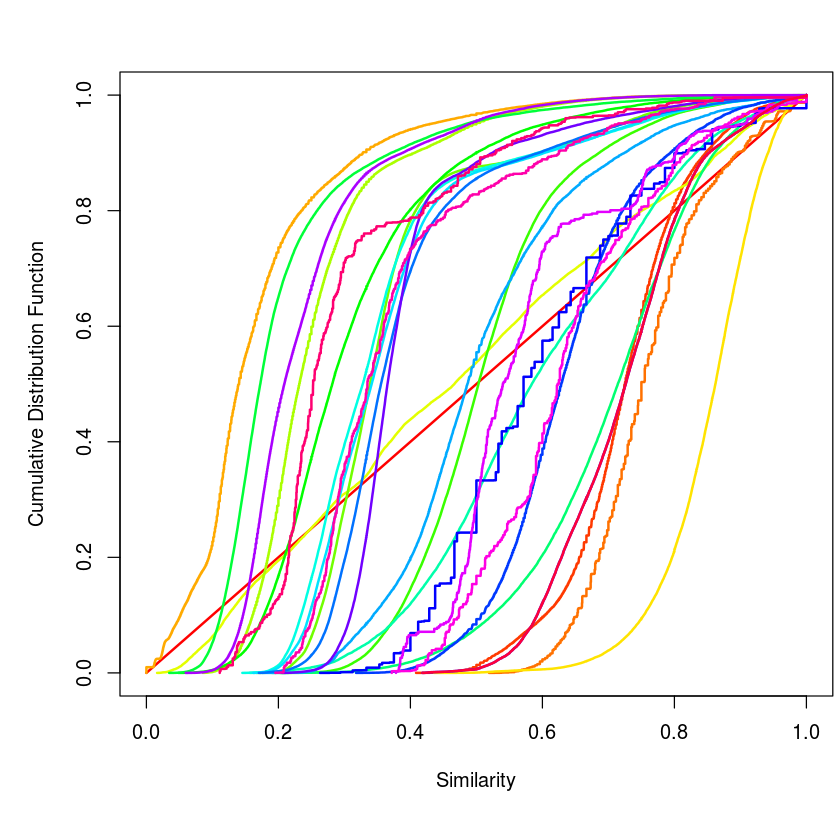

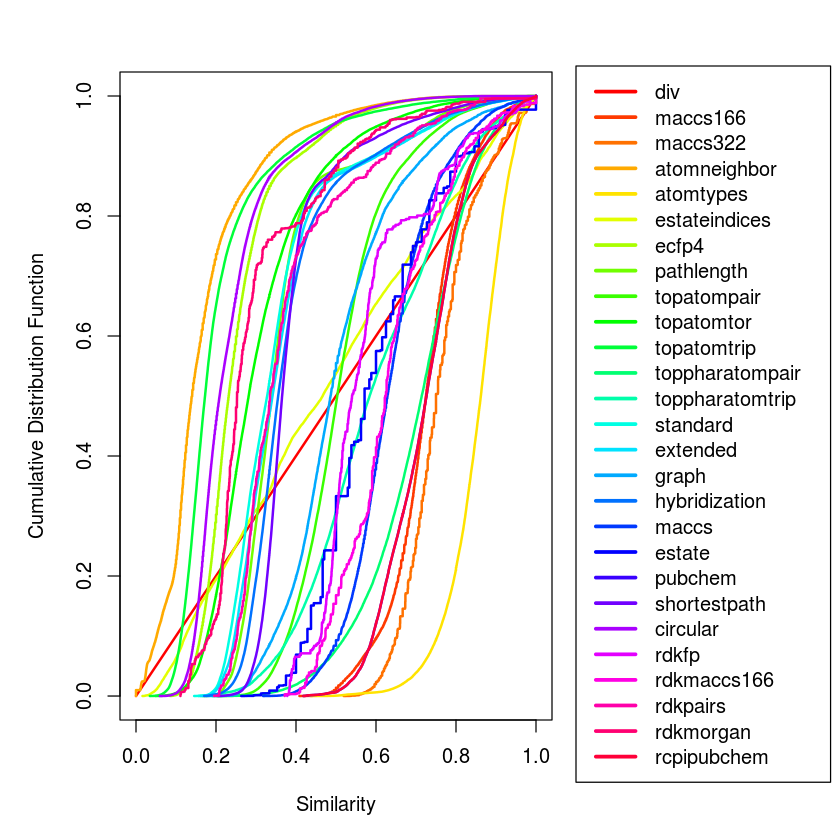

In [20]:
mypalette <- rainbow(ncol(val))

par(mar=c(6, 5, 3, 0.3),xpd=FALSE)
matplot(x=val, xlab="Similarity", y=div, ylab="Cumulative Distribution Function", type='l', lty=1, lwd=2, col=mypalette)
legend(1.1, 1.05, legend=colnames(val), lwd=3, col=mypalette)

par(mar=c(5, 5, 3, 12), xpd=TRUE)
matplot(x=val, xlab="Similarity", y=div, ylab="Cumulative Distribution Function", type='l', lty=1, lwd=2, col=mypalette)
legend(1.1, 1.05, legend=colnames(val), lwd=3, col=mypalette)

### III.3. Statistics

In [21]:
summary(val)
write.table(summary(val), 'FP_statistics.txt', sep=' ')

      div              maccs166         maccs322       atomneighbor   
 Min.   :1.74e-05   Min.   :0.4086   Min.   :0.5192   Min.   :0.0000  
 1st Qu.:2.50e-01   1st Qu.:0.6707   1st Qu.:0.7000   1st Qu.:0.1039  
 Median :5.00e-01   Median :0.7250   Median :0.7500   Median :0.1404  
 Mean   :5.00e-01   Mean   :0.7256   Mean   :0.7619   Mean   :0.1732  
 3rd Qu.:7.50e-01   3rd Qu.:0.7805   3rd Qu.:0.8125   3rd Qu.:0.2069  
 Max.   :1.00e+00   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
   atomtypes      estateindices        ecfp4          pathlength    
 Min.   :0.4358   Min.   :0.0162   Min.   :0.0855   Min.   :0.1667  
 1st Qu.:0.8108   1st Qu.:0.2495   1st Qu.:0.1923   1st Qu.:0.2929  
 Median :0.8621   Median :0.4666   Median :0.2316   Median :0.3388  
 Mean   :0.8525   Mean   :0.4794   Mean   :0.2600   Mean   :0.3749  
 3rd Qu.:0.9060   3rd Qu.:0.6972   3rd Qu.:0.2903   3rd Qu.:0.3883  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :0.9972  
  topatompair       

### III.4. Correlation matrix

In [22]:
cor(allfps)
write.table(cor(allfps), 'FP_correlation-matrix.txt', sep=' ')

,maccs166,maccs322,atomneighbor,atomtypes,estateindices,ecfp4,pathlength,topatompair,topatomtor,topatomtrip,⋯,maccs,estate,pubchem,shortestpath,circular,rdkfp,rdkmaccs166,rdkpairs,rdkmorgan,rcpipubchem
maccs166,1.00000000,0.85116436,0.53989566,0.46087809,0.37393930,0.63499509,0.64329930,0.63083310,0.55116851,0.61088902,⋯,0.93549686,0.66811683,0.75284341,0.58455679,0.59562702,0.04123279,0.036293503,0.033867955,0.029447024,0.75284341
maccs322,0.85116436,1.00000000,0.54015712,0.42053033,0.44067083,0.63258736,0.67699477,0.61266824,0.55276970,0.62501005,⋯,0.86619739,0.66453540,0.68358518,0.61797966,0.58924119,0.06047179,0.041111054,0.039207756,0.040330215,0.68358518
atomneighbor,0.53989566,0.54015712,1.00000000,0.34276976,0.35847003,0.91136769,0.83507511,0.67847015,0.86827181,0.82455967,⋯,0.56258767,0.43562988,0.61279652,0.71091319,0.88317110,0.06575384,0.051306322,0.053124531,0.051118897,0.61279652
atomtypes,0.46087809,0.42053033,0.34276976,1.00000000,0.54307596,0.35869482,0.34553094,0.76111838,0.41696982,0.51434034,⋯,0.51580832,0.44396492,0.30387509,0.34154049,0.34118397,0.01834051,0.019450280,0.015914553,0.012046038,0.30387509
estateindices,0.37393930,0.44067083,0.35847003,0.54307596,1.00000000,0.34279253,0.30761170,0.43415083,0.33670895,0.36419348,⋯,0.40694386,0.44969160,0.31794984,0.29728685,0.32456010,-0.01053907,-0.014839350,-0.017369365,-0.015139414,0.31794984
ecfp4,0.63499509,0.63258736,0.91136769,0.35869482,0.34279253,1.00000000,0.92639985,0.70603404,0.83687961,0.83984129,⋯,0.66548333,0.57423716,0.73568720,0.80664128,0.96272230,0.08919411,0.070479935,0.072854505,0.068598409,0.73568720
pathlength,0.64329930,0.67699477,0.83507511,0.34553094,0.30761170,0.92639985,1.00000000,0.69869842,0.79423561,0.82744716,⋯,0.68508334,0.58005407,0.73197580,0.88642218,0.91264239,0.11312956,0.091586174,0.093413314,0.088038536,0.73197580
topatompair,0.63083310,0.61266824,0.67847015,0.76111838,0.43415083,0.70603404,0.69869842,1.00000000,0.77032311,0.90483728,⋯,0.69220260,0.52908802,0.53130320,0.66419220,0.70282377,0.05863852,0.049257899,0.049035404,0.045393898,0.53130320
topatomtor,0.55116851,0.55276970,0.86827181,0.41696982,0.33670895,0.83687961,0.79423561,0.77032311,1.00000000,0.85726671,⋯,0.58704726,0.43349755,0.59528109,0.69893112,0.83211463,0.05999095,0.050057633,0.045421170,0.043063555,0.59528109
topatomtrip,0.61088902,0.62501005,0.82455967,0.51434034,0.36419348,0.83984129,0.82744716,0.90483728,0.85726671,1.00000000,⋯,0.66846287,0.49916054,0.57647997,0.78933490,0.83697146,0.06789501,0.052956034,0.053289904,0.050579015,0.57647997


## IV. Select best FP

### IV.1. FPs
#### Option 1: One FP

In [23]:
bfp1 <- mctfp5
bfp1s <- melt(bfp1)[melt(lower.tri(bfp1))$value,]

#### Option 2: Mean Similarity

In [24]:
bfp2 <- (mctfp5 + mctfp11)/2
bfp2s <- melt(bfp2)[melt(lower.tri(bfp2))$value,]

#### Merge

In [25]:
bfpst <- data.frame(bfp1s[3], bfp2s[3])
colnames(bfpst) <- c("OneFP", "MeanSim")

### IV.2. Plot

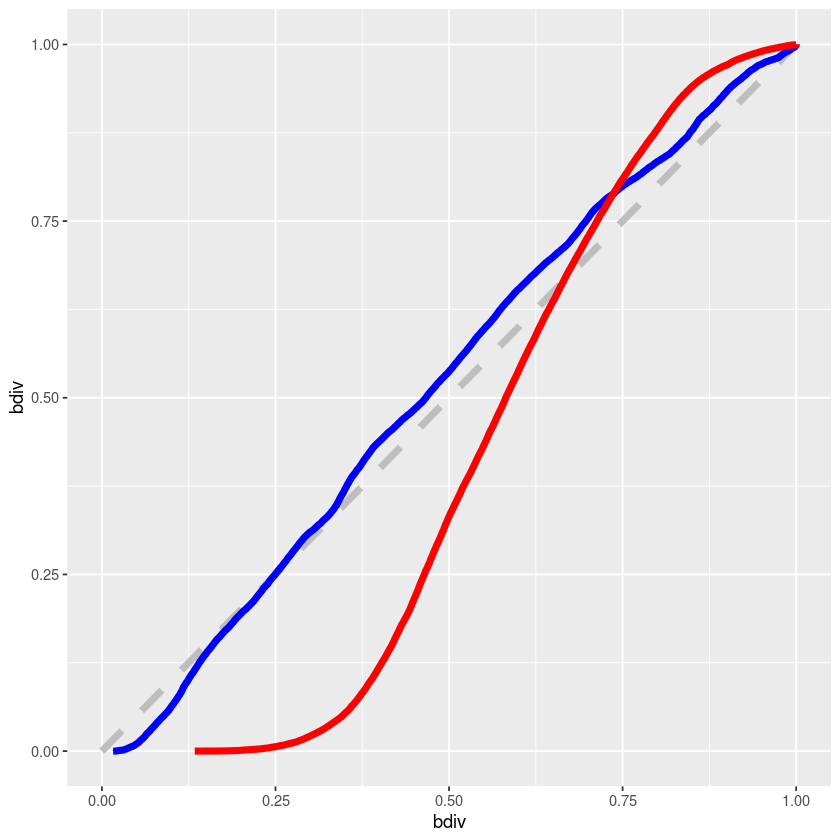

In [26]:
bfpsort <- data.frame(lapply(bfpst,sort))
bdiv <- (seq.int(nrow(bfpsort)))/(nrow(bfpsort))
bval <- data.frame(bdiv,bfpsort)

ggplot() + 
geom_line(data=bval, aes(x=bdiv, y=bdiv), color='gray', lty=2, lwd=2) +
geom_line(data=bval, aes(x=OneFP, y=bdiv), color='blue', lwd=2) +
geom_line(data=bval, aes(x=MeanSim, y=bdiv), color='red', lwd=2)

### IV.3. Statistics

In [27]:
summary(bval)
write.table(summary(bval), 'Best_FP_statistics.txt', sep=' ')

      bdiv              OneFP           MeanSim      
 Min.   :1.74e-05   Min.   :0.0162   Min.   :0.1336  
 1st Qu.:2.50e-01   1st Qu.:0.2495   1st Qu.:0.4643  
 Median :5.00e-01   Median :0.4666   Median :0.5817  
 Mean   :5.00e-01   Mean   :0.4794   Mean   :0.5912  
 3rd Qu.:7.50e-01   3rd Qu.:0.6972   3rd Qu.:0.7131  
 Max.   :1.00e+00   Max.   :1.0000   Max.   :1.0000  

### IV.4. Select FP

In [28]:
bfp <- bfp1
bfps <- melt(bfp)[melt(lower.tri(bfp))$value,]

## V. Activity Difference

In [29]:
ad <- matrix(cdkf[['pIC50']],ncol=1)
m <- t(outer(ad[,1],ad[,1],'-'))

id <- unlist(strsplit(toString(cdkf[['ID']]), split=', '))
colnames (m) <- c(id)
row.names (m) <- id

m2 <- melt(m)[melt(lower.tri(m))$value,]

In [30]:
adfps <- data.frame(m2[2], m2[1], bfps[3], abs(m2[3]))
colnames(adfps) <- c("ID1", "ID2", "Tanimoto_Similarity", "Activity_Difference")

## VI. Zone filtering

### VI.1. Tanimoto Similarity

In [31]:
ts <- adfps[['Tanimoto_Similarity']]
z13 <- adfps[['Tanimoto_Similarity']]
z24 <- adfps[['Tanimoto_Similarity']]

tsmedian <- median(ts)
tsstd <- sd(ts)

write.table(data.frame(tsmedian,tsstd), 'TS_Median_STD.txt', sep=' ')

eq <- function(x){(median(x) + ( 2 * (sd(x))))}; xthreshold <- eq(ts)
#xthreshold <- median(ts)
#xthreshold <- 0.8

z13[z13 > xthreshold] <- NA
z24[z24 <= xthreshold] <- NA

### VI.2. Activity Difference

In [32]:
ad <- adfps[['Activity_Difference']]
z12 <- adfps[['Activity_Difference']]
z34 <- adfps[['Activity_Difference']]

admedian <- median(ad)
adstd <- sd(ad)

write.table(data.frame(admedian,adstd), 'Activity_Difference_Median_STD.txt', sep=' ')

eq <- function(x){(median(x) + ( 2 * (sd(x))))}; ythreshold <- eq(ad)
#ythreshold <- median(ad)
#ythreshold <- 0.8

z12[z12 > ythreshold] <- NA
z34[z34 <= ythreshold] <- NA

### VI.3. Zones

In [33]:
z1 <- na.omit(data.frame(m2[2], m2[1], z13, z12))
colnames(z1) <- c("ID1", "ID2", "TS", "AD")
z2 <- na.omit(data.frame(m2[2], m2[1], z24, z12))
colnames(z2) <- c("ID1", "ID2", "TS", "AD")
z3 <- na.omit(data.frame(m2[2], m2[1], z13, z34))
colnames(z3) <- c("ID1", "ID2", "TS", "AD")
z4 <- na.omit(data.frame(m2[2], m2[1], z24, z34))
colnames(z4) <- c("ID1", "ID2", "TS", "AD")

### VI.4. Frequency

In [34]:
z1f <- as.data.frame(table(z1$ID1))
z2f <- as.data.frame(table(z2$ID1))
z3f <- as.data.frame(table(z3$ID1))
z4f <- as.data.frame(table(z4$ID1))

z1f <- z1f[order(-z1f$Freq),]
z2f <- z2f[order(-z2f$Freq),]
z3f <- z3f[order(-z3f$Freq),]
z4f <- z4f[order(-z4f$Freq),]

### VI.4. SAS map

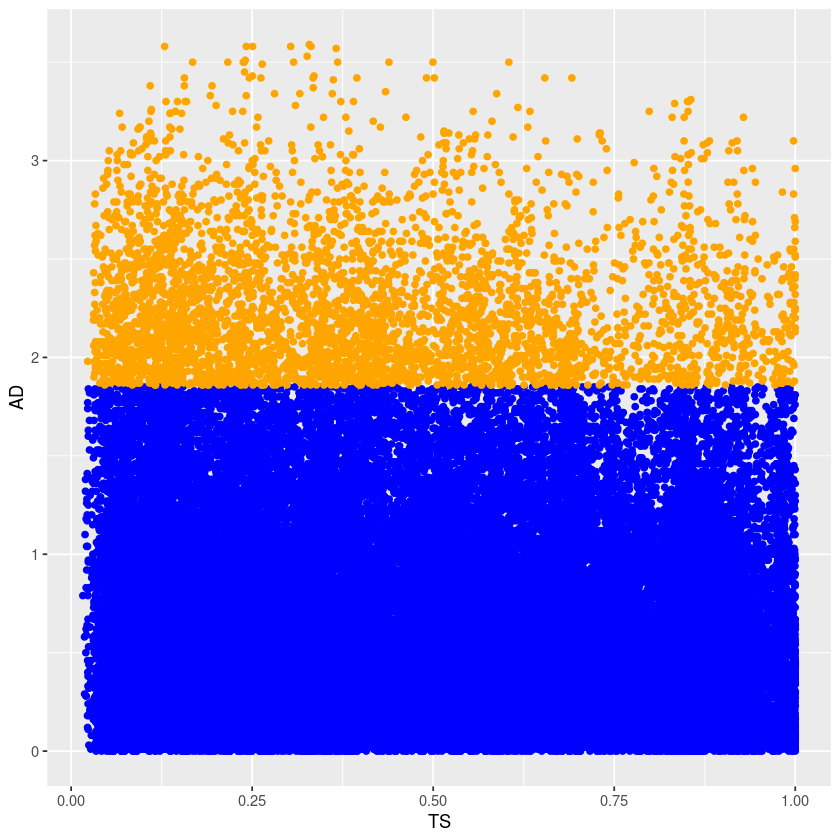

In [35]:
#with(fps,plot(Tanimoto_Similarity,Activity_Difference))
ggplot() + 
geom_point(data=z1, aes(x=TS, y=AD), color='blue') + 
geom_point(data=z2, aes(x=TS, y=AD), color='green') +
geom_point(data=z3, aes(x=TS, y=AD), color='orange') +
geom_point(data=z4, aes(x=TS, y=AD), color='red')

## VII. Hierarchical Clustering

### VII.1. Clusters

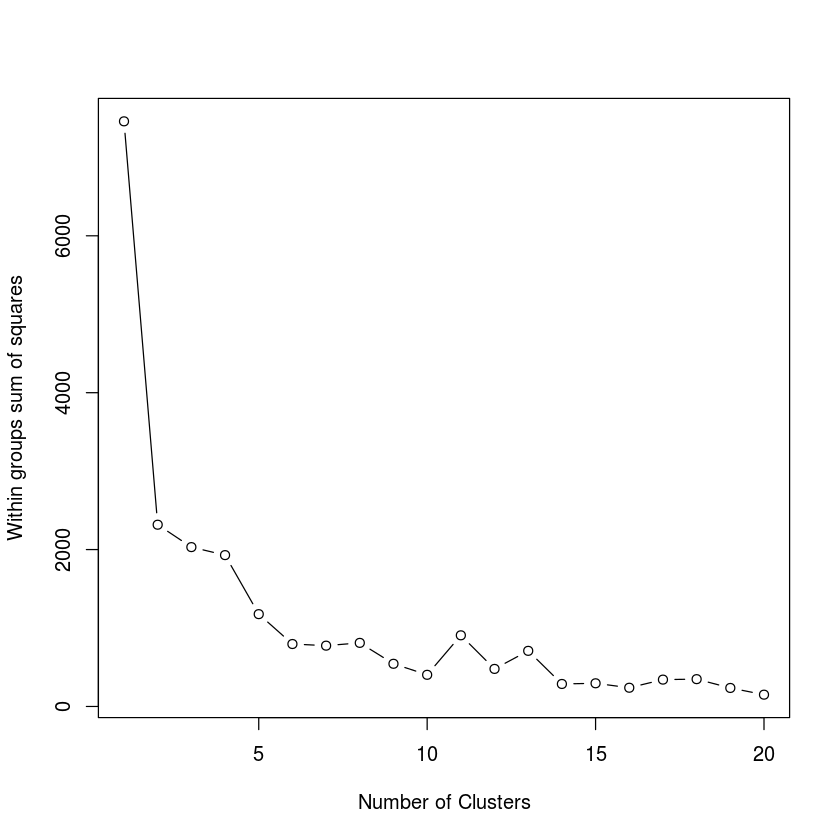

In [36]:
fp.dist <- 1 - bfp
wss <- (nrow(fp.dist)-1)*sum(apply(fp.dist,2,var))
for (i in 2:20) wss[i] <- sum(kmeans(fp.dist, centers=i)$withinss)
plot(1:20, wss, type='b', xlab='Number of Clusters', ylab='Within groups sum of squares')

### VII.2. Dendrogram

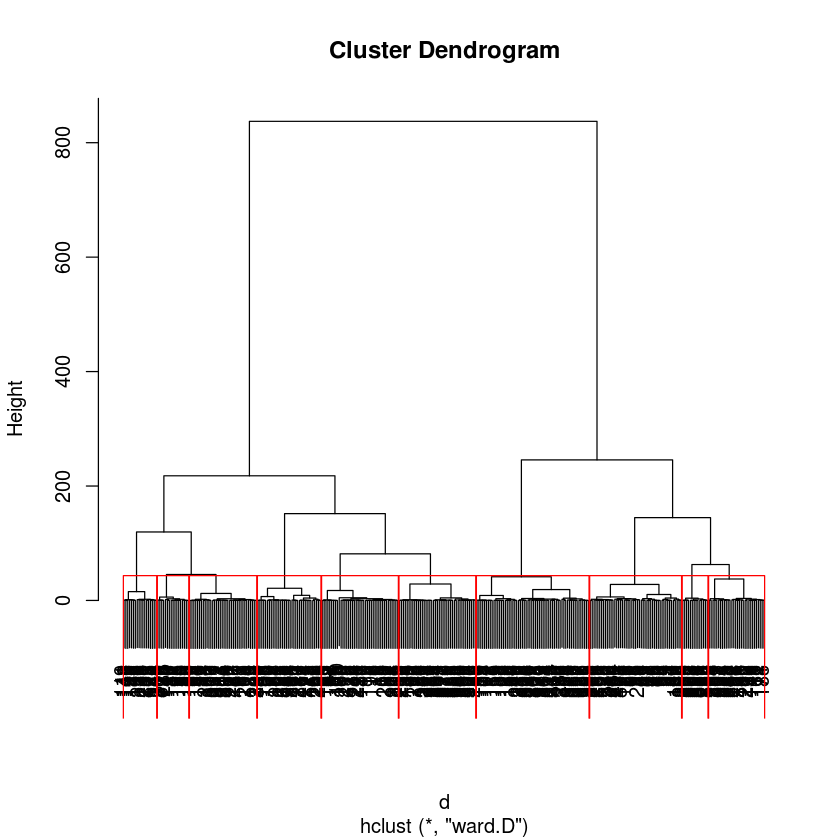

In [37]:
grupo <- 10
fit <- kmeans(fp.dist, grupo)
fp.dist <- data.frame(fp.dist, fit$cluster)
d <- dist(fp.dist, method = 'euclidean')
fit <- hclust(d, method='ward.D')
plot(fit)
groups <- cutree(fit, k=grupo)
rect.hclust(fit, k=grupo, border='red')

## VIII. Write results

In [38]:
write.table(adfps, 'SAS.txt', sep=' ')
write.table(z1, 'Zone1.txt', sep=' ')
write.table(z2, 'Zone2.txt', sep=' ')
write.table(z3, 'Zone3.txt', sep=' ')
write.table(z4, 'Zone4.txt', sep=' ')
write.table(z1f, 'Zone1_Freq.txt', sep=' ')
write.table(z2f, 'Zone2_Freq.txt', sep=' ')
write.table(z3f, 'Zone3_Freq.txt', sep=' ')
write.table(z4f, 'Zone4_Freq.txt', sep=' ')
write.table(data.frame(groups), 'HC.txt', sep=' ')